In [1]:
%matplotlib inline
'''
How to Optimize Your Dragon: V1
Import initialized model and start the optimization
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF# , check_violate_constraint
from utility.data_utility import cal_cnumber
from utility.time_utility import create_filename_time, log_now, log_end

2018-07-12 17:58:44 - Start Program


In [2]:
product = {}
product['napha'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 5 and cal_cnumber(i) <= 7]
product['gasoline'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 8 and cal_cnumber(i) <= 12]
product['diesel'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 13 and cal_cnumber(i) <= 18]
product['heavy'] = [i for i in m.COMP_ORG if cal_cnumber(i) >= 19 and cal_cnumber(i) <= 56]

In [3]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'

In [4]:
def see_product(model):
    cd_x_data = []; rf_x_data = {}; rb_x_data = []

    cd_x_data = trans_product_mole({i:model.condenser.x[i].value for i in m.COMP_TOTAL})
    for j in model.reactive:
        rf_x_data[j] = trans_product_mole({i:model.reactive[j].x[i].value for i in m.COMP_TOTAL})
    rb_x_data = trans_product_mole({i:model.reboiler.x[i].value for i in m.COMP_TOTAL})

    print('Napha:\t\t{:.2f}'.format(cd_x_data['scaled']['napha']))
    print('Gasoline:\t{:.2f}'.format(rf_x_data[7]['scaled']['gasoline']))
    print('Diesel:\t\t{:.2f}'.format(rf_x_data[10]['scaled']['diesel']))
    print('Heavy:\t\t{:.2f}'.format(rb_x_data['scaled']['heavy']))

In [5]:
with open('./log/model/stage_20_base.pickle','rb') as f:
    model = dill.load(f)

In [6]:
# for j in model.reactive:
#     model.reactive[j].MPCC.pf.fix(0)
# model.reboiler.MPCC.pf.fix(0)

In [7]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'

opt.options['max_iter'] = 7000
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [8]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

In [9]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_out	L_out	L_Prod		W
Condenser	30.00	-134.						3.0267	0.6407	0.0337		2.0654

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	119.3	0.000	0.0000	0.000	0.00	0.000		5.7667	0.7437	0.0000		20.000
NON--[2]	131.1	0.000	0.0000	0.000	0.00	0.000		5.8697	0.6752	0.0000		20.000
NON--[3]	140.3	0.000	0.0000	0.000	0.00	0.000		5.8012	0.6136	0.0000		20.000
NON--[4]	148.7	0.000	0.0000	0.000	0.00	0.000		5.7396	0.5249	0.0218		20.000
NON--[5]	157.3	0.000	0.0000	0.000	0.00	0.000		5.6727	0.4430	0.0000		20.000
NON--[6]	167.3	0.000	0.0000	0.000	0.00	0.000		5.5909	0.3311	0.0000		20.000
NON--[7]	181.1	0.000	0.0000	0.000	0.00	0.000		5.4790	0.1558	0.0389		20.000
React[8]	200.0	-24.4	0.1555	0.201	1.00	3000.		5.3427	0.0

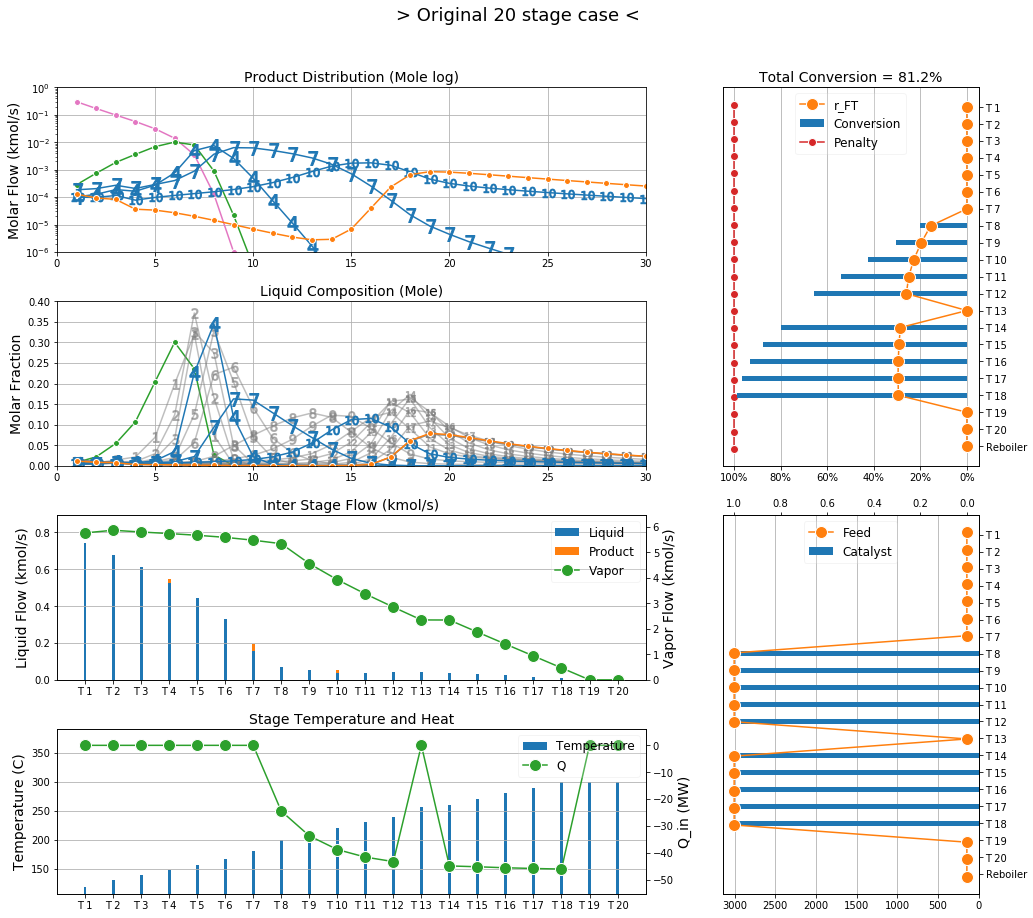

In [10]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Original 20 stage case')

# Optimization Input

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19


**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

### Parameters

In [11]:
for j in range(8,13):
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
for j in range(14,19):
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

### Constraints

In [12]:
model.quality_coefficient = pe.Param(within=pe.NonNegativeReals,mutable=True,initialize=1)

In [13]:
model.product_spec_con = pe.ConstraintList()

In [14]:
model.product_spec_con.add(expr = sum(model.condenser.x[i] for i in product['napha']) >= \
                           model.quality_coefficient*0.75*sum(model.condenser.x[i] for i in m.COMP_ORG));
model.product_spec_con.add(expr = sum(model.reactive[7].x[i] for i in product['gasoline']) >= \
                           model.quality_coefficient*0.75*sum(model.reactive[7].x[i] for i in m.COMP_ORG));
model.product_spec_con.add(expr = sum(model.reactive[10].x[i] for i in product['diesel']) >= \
                           model.quality_coefficient*0.6*sum(model.reactive[10].x[i] for i in m.COMP_ORG));
model.product_spec_con.add(expr = sum(model.reboiler.x[i] for i in product['heavy']) >= \
                           model.quality_coefficient*0.85*sum(model.reboiler.x[i] for i in m.COMP_ORG));

### Objective

In [15]:
model.del_component(model.obj)

In [16]:
model.obj = pe.Objective(expr = model.reactive[7].L['P'] - sum(model.reactive[j].MPCC.pf for j in model.reactive)\
                                - model.reboiler.MPCC.pf, sense = pe.maximize)

In [17]:
# increase the penalty weight
# for j in model.reactive:
#     model.reactive[j].MPCC.rho = 100
# model.reboiler.MPCC.rho = 100

In [18]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [19]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Temperature and Reflux')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Temperature and Reflux')

# Open up side-draw

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw ratio
    * PR_L: 0 - 1

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
**Objective:**
* Max gasoline production

In [20]:
model.reactive[7].PR_L.unfix()
model.reactive[10].PR_L.unfix()

In [21]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [22]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Product Side Draw')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Product Side Draw')

# Open up feed allocation

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [23]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)

In [24]:
model.total_feed_con = pe.ConstraintList()

In [25]:
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);
model.reactive[16].F.setlb(3)

In [26]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes
                   warm_start_bound_push = 1e-20                 yes
                   warm_start_init_point = yes                   yes
              warm_start_mult_bound_push = 1e-20                 yes

****************************************************

  65 -1.1341180e-01 2.85e-03 2.59e-03  -6.0 1.37e+01    -  1.00e+00 1.00e+00h  1
  66 -1.1341174e-01 1.80e-04 9.85e-05  -6.0 3.95e+00    -  1.00e+00 1.00e+00h  1
  67 -1.1341174e-01 4.04e-10 1.33e-10  -6.0 6.16e-03    -  1.00e+00 1.00e+00h  1
  68 -1.1365210e-01 9.06e-01 8.95e+00  -9.0 2.73e+02    -  5.26e-01 5.26e-01f  1
  69 -1.1377158e-01 2.04e+00 2.23e+01  -9.0 5.41e+02    -  2.70e-01 4.76e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.1382586e-01 2.86e+00 2.87e+01  -9.0 1.36e+03    -  8.61e-02 2.52e-01h  1
  71 -1.1387382e-01 3.46e+00 2.39e+01  -9.0 1.71e+03    -  2.41e-01 2.28e-01h  1
  72 -1.1387733e-01 3.42e+00 1.70e+01  -9.0 2.46e+03    -  2.86e-01 1.56e-02h  1
  73 -1.1394886e-01 1.15e+01 1.45e+01  -9.0 2.19e+03    -  1.98e-01 3.98e-01h  1
  74 -1.1395101e-01 1.14e+01 1.45e+01  -9.0 3.70e+03    -  1.28e-04 9.98e-03h  1
  75 -1.1395740e-01 1.12e+01 1.44e+01  -9.0 3.70e+03    -  4.87e-03 3.04e-02h  1
  76 -1.1398079e-01 1.22e+01


> Optimized Feed Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages		T	Q						V_out	L_out	L_Prod		W
Condenser	30.00	-148.						1.9139	0.6905	0.0767		2.3872

stages		T	Q	r_FT	Conv%	F	cat		V_out	L_out	L_Prod		P_VLE
NON--[1]	121.0	0.000	0.0000	0.000	0.00	0.000		5.0685	0.8068	0.0000		20.000
NON--[2]	129.3	0.000	0.0000	0.000	0.00	0.000		5.1848	0.7446	0.0000		20.000
NON--[3]	136.8	0.000	0.0000	0.000	0.00	0.000		5.1226	0.6992	0.0000		20.000
NON--[4]	144.2	0.000	0.0000	0.000	0.00	0.000		5.0772	0.6218	0.0259		20.000
NON--[5]	152.0	0.000	0.0000	0.000	0.00	0.000		5.0257	0.5480	0.0000		20.000
NON--[6]	161.9	0.000	0.0000	0.000	0.00	0.000		4.9520	0.4276	0.0000		20.000
NON--[7]	177.3	0.000	0.0000	0.000	0.00	0.000		4.8315	0.1523	0.1141		20.000
React[8]	200.0	-20.2	0.0400	0.100	0.11	3000.

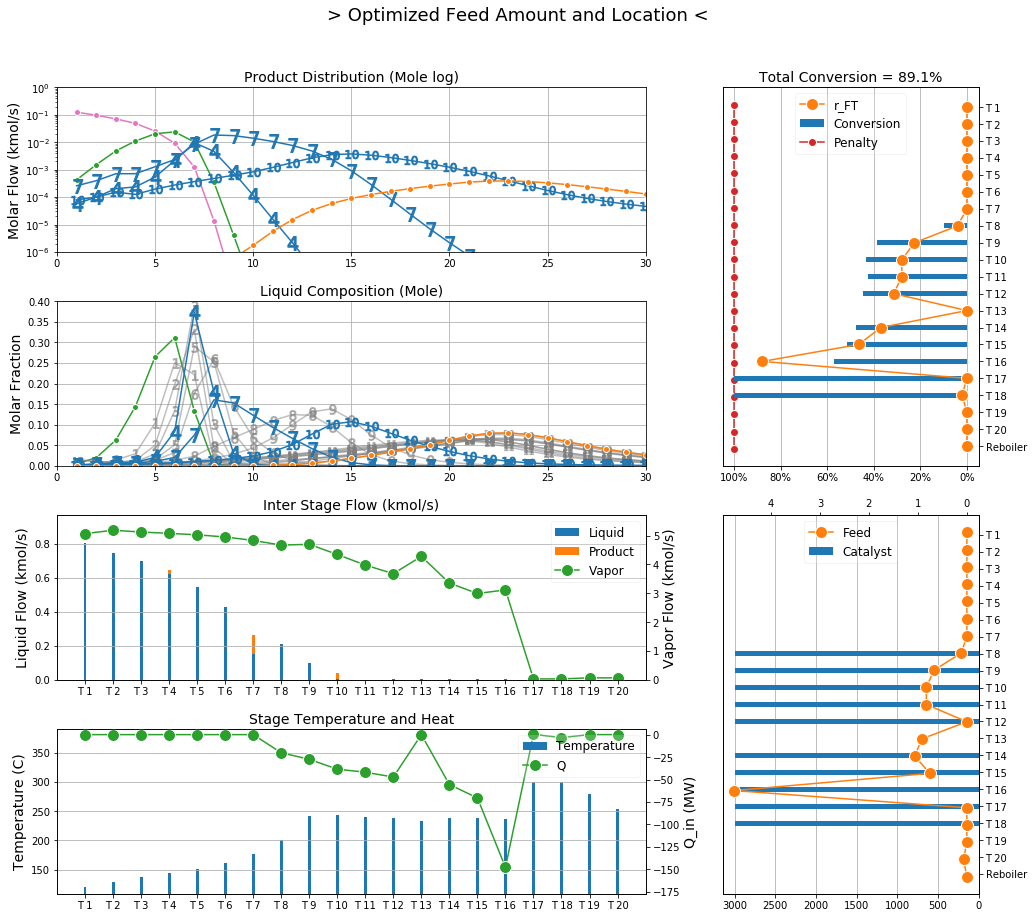

In [27]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Amount and Location')
    print('-'*108)
    beautify(pe,model)
    see_product(model)
    log_now()

plot_distribution(model,pdf,'Optimized Feed Amount and Location')

# Increase spec a little bit

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= **0.8**
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * Total feed = 10 kmol/s
    
**Objective:**
* Max gasoline production

In [28]:
# model.product_spec_con.add(expr = sum(model.reactive[7].x[i] for i in product['gasoline']) >= \
#                            model.quality_coefficient*0.8*sum(model.reactive[7].x[i] for i in m.COMP_ORG));

In [29]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [30]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Increase Gasoline Specification to 80%')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Increase Gasoline Specification to 80%')

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

**Parameters:**
* Stage Temperature
    * Rectifying section: 200C - 300C
    * Stripping section: 200C - 300C
* Reflux
    * Distillate / (Distillate + Reflux): 0.5 - 0.05, Refulx Ratio: 1 - 19
* Side-draw
    * PR_L: 0 - 1
    
* Feed
    * F: 0 - 3
        
* Catalyst
    * cat: 0 - 10000

**Constraints:**
* Product
    * Distillate: C5~C7 >= 0.75
    * Gasoline: C8~C12 >= 0.75 / 0.8
    * Diesel: C13~C18 >= 0.6
    * Heavy: C19+ >= 0.85
    
* Total feed
    * sum feed = 10 kmol/s
    
* Total catalyst
    * sum cat = 30000 kg
    
**Objective:**
* Max gasoline production

In [31]:
# for j in model.reactive:
#     model.reactive[j].cat.unfix()
#     model.reactive[j].cat.setlb(0)
#     model.reactive[j].cat.setub(30000)

In [32]:
# model.total_cat_con = pe.ConstraintList()

In [33]:
# model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [34]:
# results = opt.solve(model,tee=True)
# update_dual(pe,model)

In [35]:
# with HiddenLogs(log_text_dir):
#     print('\n>','Optimized Catalyst Amount and Location')
#     print('-'*108)
#     beautify(pe,model)
#     see_product(model)
#     log_now()

# plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')

In [36]:
pdf.close()